# to get numbers for Table 2 in the technical 

CHange the line 2 in the second box to compare different methods of calculating a spectrum

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
sys.path.append(os.path.abspath("/Users/miraliu/Desktop/PostDocCode/PartialNephrectomy_Python"))
sys.path.append(os.path.abspath("/Users/miraliu/Desktop/PostDocCode/RenalAllograft_Python"))

#sys.path.append('../')
from ML_UsefulFunctions import *
from KidneyROIAnalyses import *
from RenalAllograftFunctions import *
from ML_Stats import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format

from scipy.stats import f_oneway


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")

# CORRECTED...

In [2]:
fileloc = '/Users/miraliu/Desktop/Data/RA/RenalAllograft_IVIM/RA_DiffusionSpectra_IVIM_CORRECTED.xlsx'
Multiexp_Data = pd.read_excel(fileloc,sheet_name = 'Sortedfourpeaks_regdNNLS_2') ## take2 or not here
Multiexp_Data["Record ID"] = Multiexp_Data["Record ID"].str.replace("_P", "_")

fileloc = '/Users/miraliu/Desktop/Data/RA/GCO202690RAMulticent-BanffScores_DATA_LABELS_2024-04-19_1316.xlsx'
RA_Database_Patients = pd.read_excel(fileloc, sheet_name = 'GCO202690RAMulticent-BanffScore',header = 0) 
RA_Database_Patients["Record ID"] = RA_Database_Patients["Record ID"].str.replace("_P", "_")


fileloc = '/Users/miraliu/Desktop/Data/RA/GCO202690RAMulticent-Octavia_DATA_LABELS_2024-04-18_1424.xlsx'
RA_wEGFR = pd.read_excel(fileloc, sheet_name = 'GCO202690RAMulticent-Octavia_DA',header = 0) 
RA_wEGFR["Record ID"] = RA_wEGFR["Record ID"].str.replace("_P", "_")


Cases_to_Run = pd.merge(Multiexp_Data, RA_Database_Patients[['Record ID', 'Interstitial Fibrosis Tubular Atrophy (ci+ct)']], how = 'inner', left_on=["Record ID"], right_on = ['Record ID'])
Cases_to_Run = Cases_to_Run.drop_duplicates(keep='first',ignore_index = True)

Cases_to_Run_cortical = Cases_to_Run.loc[Multiexp_Data['ROI Type'].str.endswith('C')]
Cases_to_Run_medullar = Cases_to_Run.loc[Multiexp_Data['ROI Type'].str.endswith('M')]

Cases_to_Run_cortical_Volunteer = Multiexp_Data.loc[Multiexp_Data['ROI Type'].str.endswith('C') & Multiexp_Data['ROI Type'].str.contains('V')  & Multiexp_Data['ROI Type'].str.contains('LK')]
Cases_to_Run_medullar_Volunteer = Multiexp_Data.loc[Multiexp_Data['ROI Type'].str.endswith('M') & Multiexp_Data['ROI Type'].str.contains('V') & Multiexp_Data['ROI Type'].str.contains('LK')]


In [3]:
RA_Database_Volunteer=Cases_to_Run_cortical_Volunteer
RA_Database_Volunteer=RA_Database_Volunteer.drop(list(RA_Database_Volunteer)[42:57], axis=1)


Original_features = list(RA_Database_Volunteer.iloc[:, 2:42].columns)
cortical_features = list()
for j in range(len(Original_features)):
    cortical_features.append('cortical ' + Original_features[j])
All_features = cortical_features

RA_Database_Volunteer.columns = ['Record ID', 'ROI Type']+ All_features 

## now add the fD
RA_Database_Volunteer['fD blood mean']=RA_Database_Volunteer['cortical mean f blood']*RA_Database_Volunteer['cortical mean D blood']
RA_Database_Volunteer['fD tubule mean']=RA_Database_Volunteer['cortical mean f tubule']*RA_Database_Volunteer['cortical mean D tubule']
RA_Database_Volunteer['fD tissue mean']=RA_Database_Volunteer['cortical mean f tissue']*RA_Database_Volunteer['cortical mean D tissue']
RA_Database_Volunteer['fD fibro mean']=RA_Database_Volunteer['cortical mean f fibro']*RA_Database_Volunteer['cortical mean D fibro']

RA_Database_Volunteer['fD blood median']=RA_Database_Volunteer['cortical median f blood']*RA_Database_Volunteer['cortical median D blood']
RA_Database_Volunteer['fD tubule median']=RA_Database_Volunteer['cortical median f tubule']*RA_Database_Volunteer['cortical median D tubule']
RA_Database_Volunteer['fD tissue median']=RA_Database_Volunteer['cortical median f tissue']*RA_Database_Volunteer['cortical median D tissue']
RA_Database_Volunteer['fD fibro median']=RA_Database_Volunteer['cortical median f fibro']*RA_Database_Volunteer['cortical median D fibro']



## add slow compartment


RA_Database_Volunteer['D slow combined mean']=(RA_Database_Volunteer['cortical mean f tissue']*RA_Database_Volunteer['cortical mean D tissue'] + RA_Database_Volunteer['cortical mean f fibro']*RA_Database_Volunteer['cortical mean D fibro'])/(RA_Database_Volunteer['cortical mean f tissue'] + RA_Database_Volunteer['cortical mean f fibro'])
RA_Database_Volunteer['f slow combined mean']=RA_Database_Volunteer['cortical mean f tissue'] + RA_Database_Volunteer['cortical mean f fibro']


RA_Database_Volunteer['D slow combined median']=(RA_Database_Volunteer['cortical median f tissue']*RA_Database_Volunteer['cortical median D tissue'] + RA_Database_Volunteer['cortical median f fibro']*RA_Database_Volunteer['cortical median D fibro'])/(RA_Database_Volunteer['cortical median f tissue'] + RA_Database_Volunteer['cortical median f fibro'])
RA_Database_Volunteer['f slow combined median']=RA_Database_Volunteer['cortical median f tissue'] + RA_Database_Volunteer['cortical median f fibro']




In [4]:

RA_Database_Patient  = Cases_to_Run.dropna(subset = 'Interstitial Fibrosis Tubular Atrophy (ci+ct)')

RA_Database_Patient=RA_Database_Patient.drop(columns=list(RA_Database_Patient)[42:57], axis=1)

In [5]:


Original_features = list(RA_Database_Patient.iloc[:, 2:42].columns)
cortical_features = list()
for j in range(len(Original_features)):
    cortical_features.append('cortical ' + Original_features[j])
All_features = cortical_features

RA_Database_Patient.columns = ['Record ID', 'ROI Type']+ All_features + ['IFTA']

## now add the fD
RA_Database_Patient['fD blood mean']=RA_Database_Patient['cortical mean f blood']*RA_Database_Patient['cortical mean D blood']
RA_Database_Patient['fD tubule mean']=RA_Database_Patient['cortical mean f tubule']*RA_Database_Patient['cortical mean D tubule']
RA_Database_Patient['fD tissue mean']=RA_Database_Patient['cortical mean f tissue']*RA_Database_Patient['cortical mean D tissue']
RA_Database_Patient['fD fibro mean']=RA_Database_Patient['cortical mean f fibro']*RA_Database_Patient['cortical mean D fibro']

RA_Database_Patient['fD blood median']=RA_Database_Patient['cortical median f blood']*RA_Database_Patient['cortical median D blood']
RA_Database_Patient['fD tubule median']=RA_Database_Patient['cortical median f tubule']*RA_Database_Patient['cortical median D tubule']
RA_Database_Patient['fD tissue median']=RA_Database_Patient['cortical median f tissue']*RA_Database_Patient['cortical median D tissue']
RA_Database_Patient['fD fibro median']=RA_Database_Patient['cortical median f fibro']*RA_Database_Patient['cortical median D fibro']


RA_Database_Patient['D slow combined mean']=(RA_Database_Patient['cortical mean f tissue']*RA_Database_Patient['cortical mean D tissue'] + RA_Database_Patient['cortical mean f fibro']*RA_Database_Patient['cortical mean D fibro'])/(RA_Database_Patient['cortical mean f tissue'] + RA_Database_Patient['cortical mean f fibro'])
RA_Database_Patient['f slow combined mean']=RA_Database_Patient['cortical mean f tissue'] + RA_Database_Patient['cortical mean f fibro']


RA_Database_Patient['D slow combined median']=(RA_Database_Patient['cortical median f tissue']*RA_Database_Patient['cortical median D tissue'] + RA_Database_Patient['cortical median f fibro']*RA_Database_Patient['cortical median D fibro'])/(RA_Database_Patient['cortical median f tissue'] + RA_Database_Patient['cortical median f fibro'])
RA_Database_Patient['f slow combined median']=RA_Database_Patient['cortical median f tissue'] + RA_Database_Patient['cortical median f fibro']



In [6]:


RA_Database_Patient = pd.merge(RA_Database_Patient, RA_wEGFR[['Record ID', 'GFR CKD EPI']], how = 'inner', left_on=["Record ID"], right_on = ['Record ID'])
RA_Database_Patient.insert(55, 'IFTA',RA_Database_Patient.pop('IFTA'))

RA_Database_Patient = RA_Database_Patient.drop_duplicates(subset=['Record ID'])
RA_Database_Patient

,Record ID,ROI Type,cortical mean f blood,cortical median f blood,cortical std f blood,cortical kurtosis f blood,cortical skew f blood,cortical mean f tubule,cortical median f tubule,cortical std f tubule,...,fD blood median,fD tubule median,fD tissue median,fD fibro median,D slow combined mean,f slow combined mean,D slow combined median,f slow combined median,GFR CKD EPI,IFTA
0,RA_01_001,RA_01_P001_C,0.094,0.095,0.071,2.623,0.450,0.025,0.000,0.056,...,16.608,0.000,1.535,0.000,1.774,0.881,1.748,0.878,30.000,0.000
1,RA_01_002,RA_01_P002_C,0.046,0.000,0.079,4.363,1.654,0.002,0.000,0.012,...,0.000,0.000,1.761,0.000,1.961,0.952,1.960,0.898,58.000,2.000
2,RA_01_003,RA_01_P003_C,0.081,0.053,0.091,2.734,0.825,0.027,0.000,0.070,...,4.453,0.000,1.414,0.000,1.756,0.892,1.734,0.815,56.000,0.000
3,RA_01_006,RA_01_P006_C,0.097,0.090,0.077,2.515,0.478,0.006,0.000,0.038,...,16.268,0.000,1.811,0.000,2.199,0.897,2.188,0.828,14.000,0.000
4,RA_01_007,RA_01_P007_C,0.047,0.000,0.080,4.854,1.704,0.081,0.000,0.119,...,0.000,0.000,1.282,0.013,1.699,0.871,1.631,0.794,45.000,0.000
5,RA_01_008,RA_01_P008_C,0.040,0.000,0.062,3.917,1.399,0.026,0.000,0.095,...,0.000,0.000,1.567,0.086,1.872,0.934,1.769,0.934,29.000,2.000
6,RA_01_009,RA_01_P009_C,0.139,0.119,0.125,4.198,1.007,0.054,0.000,0.080,...,20.742,0.000,1.661,0.041,2.155,0.807,2.133,0.798,26.000,4.000
7,RA_01_010,RA_01_P010_C,0.106,0.107,0.090,2.033,0.341,0.015,0.000,0.051,...,19.020,0.000,1.996,0.000,2.455,0.879,2.414,0.827,49.000,0.000
8,RA_01_011,RA_01_P011_C,0.093,0.036,0.123,4.237,1.404,0.027,0.000,0.086,...,3.365,0.000,2.049,0.059,2.321,0.881,2.402,0.878,28.000,2.000
9,RA_01_014,RA_01_P014_C,0.062,0.047,0.069,3.156,0.991,0.098,0.000,0.145,...,5.197,0.000,1.489,0.026,2.007,0.840,1.994,0.759,58.000,0.000


In [7]:
RA_Database_Patient = RA_Database_Patient.drop(RA_Database_Patient.filter(regex='slow').columns, axis=1)
RA_Database_Patient = RA_Database_Patient.drop(RA_Database_Patient.filter(regex='fibro').columns, axis=1)

RA_Database_Volunteer = RA_Database_Volunteer.drop(RA_Database_Volunteer.filter(regex='slow').columns, axis=1)
RA_Database_Volunteer = RA_Database_Volunteer.drop(RA_Database_Volunteer.filter(regex='fibro').columns, axis=1)


In [8]:
df = RA_Database_Patient.dropna(subset = 'IFTA')
df = df.dropna(subset = 'GFR CKD EPI')


## NOTE THE RENUMBERING IN ORDER OF DECREASE
df['allograft status'] = df['GFR CKD EPI']
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] == 0)] = 0 #'Healthy Function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] == 0)] = 1 #'No fibrosis impaired function'
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] > 0)] = 2 #'Fibrosis with normal function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] > 0)] = 3 #'Fibrosis with impaired function'


df_healthyallo = df.loc[df['allograft status']==  0]
df_impfunc = df.loc[df['allograft status'] == 1]
df_fibro = df.loc[df['allograft status'] == 2]
df_fibroimpfunc = df.loc[df['allograft status'] == 3]
df_anyclinical = df.loc[df['allograft status'] > 0]

df_healthyallo = df_healthyallo.drop(list(df_healthyallo)[54:57], axis=1)
df_impfunc=df_impfunc.drop(list(df_impfunc)[54:57], axis=1)
df_fibro= df_fibro.drop(list(df_fibro)[54:57], axis=1)
df_fibroimpfunc= df_fibroimpfunc.drop(list(df_fibroimpfunc)[54:57], axis=1)
df_anyclinical= df_anyclinical.drop(list(df_anyclinical)[54:57], axis=1)



In [9]:
def false_discovery_control(ps, *, axis=0, method='bh'):

    # Input Validation and Special Cases
    ps = np.asarray(ps)
    #print(ps)

    ps_in_range = (np.issubdtype(ps.dtype, np.number)
                   and np.all(ps == np.clip(ps, 0, 1)))
    #if not ps_in_range:
        #raise ValueError("`ps` must include only numbers between 0 and 1.")

    methods = {'bh', 'by'}
    if method.lower() not in methods:
        raise ValueError(f"Unrecognized `method` '{method}'."
                         f"Method must be one of {methods}.")
    method = method.lower()

    if axis is None:
        axis = 0
        ps = ps.ravel()

    axis = np.asarray(axis)[()]
    if not np.issubdtype(axis.dtype, np.integer) or axis.size != 1:
        raise ValueError("`axis` must be an integer or `None`")

    if ps.size <= 1 or ps.shape[axis] <= 1:
        return ps[()]

    ps = np.moveaxis(ps, axis, -1)
    m = ps.shape[-1]

    # Main Algorithm
    # Equivalent to the ideas of [1] and [2], except that this adjusts the
    # p-values as described in [3]. The results are similar to those produced
    # by R's p.adjust.

    # "Let [ps] be the ordered observed p-values..."
    order = np.argsort(ps, axis=-1)
    ps = np.take_along_axis(ps, order, axis=-1)  # this copies ps

    # Equation 1 of [1] rearranged to reject when p is less than specified q
    i = np.arange(1, m+1)
    ps *= m / i

    # Theorem 1.3 of [2]
    if method == 'by':
        ps *= np.sum(1 / i)

    # accounts for rejecting all null hypotheses i for i < k, where k is
    # defined in Eq. 1 of either [1] or [2]. See [3]. Starting with the index j
    # of the second to last element, we replace element j with element j+1 if
    # the latter is smaller.
    np.minimum.accumulate(ps[..., ::-1], out=ps[..., ::-1], axis=-1)

    # Restore original order of axes and data
    np.put_along_axis(ps, order, values=ps.copy(), axis=-1)
    ps = np.moveaxis(ps, -1, axis)

    return np.clip(ps, 0, 1)

In [10]:
# input two dataframes with matching columns, and calculate ranksums across all columns
def testranksums(df1, df2):
    comparisons = df1.columns
    dummy = np.empty((len(comparisons)-2,4),dtype=object)
    for j in range(2,len(comparisons)):
        out = scipy.stats.ranksums(df1[comparisons[j]], df2[comparisons[j]])
        dummy[j-2,:]=[comparisons[j], [round(df1[comparisons[j]].mean(),2), '±',round(df1[comparisons[j]].std(),2)], [round(df2[comparisons[j]].mean(),2),'±',round(df2[comparisons[j]].std(),2)], out[1]]
        #if out[1] < 0.09:
            #print('\n', comparisons[j])
            #print(round(df1[comparisons[j]].mean(),2), '±',round(df1[comparisons[j]].std(),2), 'vs.', round(df2[comparisons[j]].mean(),2),'±',round(df2[comparisons[j]].std(),2))
            #print('ranksum stat = ', round(out[0],2), 'p = ', round(out[1], 3))
    #print(dummy)   
    pval_df = pd.DataFrame({'Feature': dummy[:, 0], 'healthy': dummy[:,1],'pathological': dummy[:,2], 'p-value': dummy[:, 3]}).sort_values('p-value')
    pval_df = pval_df.replace(1, 0.999)
    #display(pval_df)
    corrected_p = false_discovery_control(pval_df['p-value'])
    corrected_p = [round(x, 3) for x in corrected_p]
    pval_df['bh p-value'] = corrected_p
    display(pval_df.loc[pval_df['p-value'] <= 0.05])

In [11]:
print('Healthy volunteer vs. Allografts with healthy function & no fibrosis', len(df_healthyallo))
testranksums(RA_Database_Volunteer, df_healthyallo)


Healthy volunteer vs. Allografts with healthy function & no fibrosis 13


,Feature,healthy,pathological,p-value,bh p-value


In [12]:
print('Healthy volunteer vs. Allografts with impaired function & no fibrosis', len(df_impfunc))
testranksums(RA_Database_Volunteer, df_impfunc)


Healthy volunteer vs. Allografts with impaired function & no fibrosis 7


,Feature,healthy,pathological,p-value,bh p-value
10,cortical mean f tissue,"[0.71, ±, 0.04]","[0.82, ±, 0.07]",0.012,0.254
31,fD tubule mean,"[1.09, ±, 0.63]","[0.29, ±, 0.34]",0.019,0.254
27,cortical std D tissue,"[1.09, ±, 0.22]","[0.63, ±, 0.32]",0.028,0.254
5,cortical mean f tubule,"[0.12, ±, 0.04]","[0.05, ±, 0.05]",0.028,0.254
7,cortical std f tubule,"[0.16, ±, 0.04]","[0.1, ±, 0.05]",0.042,0.254
11,cortical median f tissue,"[0.73, ±, 0.05]","[0.83, ±, 0.09]",0.042,0.254


In [13]:
print('Healthy volunteer vs. Allografts with healthy function & fibrosis',len(df_fibro))
testranksums(RA_Database_Volunteer, df_fibro)


Healthy volunteer vs. Allografts with healthy function & fibrosis 15


,Feature,healthy,pathological,p-value,bh p-value
5,cortical mean f tubule,"[0.12, ±, 0.04]","[0.04, ±, 0.04]",0.006,0.090
31,fD tubule mean,"[1.09, ±, 0.63]","[0.32, ±, 0.52]",0.008,0.090
10,cortical mean f tissue,"[0.71, ±, 0.04]","[0.84, ±, 0.09]",0.010,0.090
11,cortical median f tissue,"[0.73, ±, 0.05]","[0.87, ±, 0.11]",0.010,0.090
27,cortical std D tissue,"[1.09, ±, 0.22]","[0.67, ±, 0.26]",0.016,0.118
20,cortical mean D tubule,"[8.68, ±, 2.44]","[4.13, ±, 4.99]",0.032,0.167
7,cortical std f tubule,"[0.16, ±, 0.04]","[0.09, ±, 0.06]",0.032,0.167


In [14]:
print('Healthy volunteer vs. Allografts with impaired function & fibrosis', len(df_fibroimpfunc))
testranksums(RA_Database_Volunteer, df_fibroimpfunc)


Healthy volunteer vs. Allografts with impaired function & fibrosis 19


,Feature,healthy,pathological,p-value,bh p-value
10,cortical mean f tissue,"[0.71, ±, 0.04]","[0.81, ±, 0.09]",0.012,0.155
5,cortical mean f tubule,"[0.12, ±, 0.04]","[0.05, ±, 0.05]",0.014,0.155
7,cortical std f tubule,"[0.16, ±, 0.04]","[0.09, ±, 0.05]",0.014,0.155
27,cortical std D tissue,"[1.09, ±, 0.22]","[0.7, ±, 0.27]",0.017,0.155
11,cortical median f tissue,"[0.73, ±, 0.05]","[0.83, ±, 0.11]",0.030,0.217


In [15]:
print('Healthy volunteer vs. Allografts with any bad', len(df_anyclinical))
testranksums(RA_Database_Volunteer, df_anyclinical)


Healthy volunteer vs. Allografts with any bad 41


,Feature,healthy,pathological,p-value,bh p-value
10,cortical mean f tissue,"[0.71, ±, 0.04]","[0.82, ±, 0.08]",0.004,0.070
5,cortical mean f tubule,"[0.12, ±, 0.04]","[0.05, ±, 0.05]",0.005,0.070
27,cortical std D tissue,"[1.09, ±, 0.22]","[0.68, ±, 0.27]",0.009,0.070
11,cortical median f tissue,"[0.73, ±, 0.05]","[0.84, ±, 0.11]",0.011,0.070
31,fD tubule mean,"[1.09, ±, 0.63]","[0.36, ±, 0.47]",0.011,0.070
7,cortical std f tubule,"[0.16, ±, 0.04]","[0.09, ±, 0.05]",0.012,0.070
20,cortical mean D tubule,"[8.68, ±, 2.44]","[4.77, ±, 4.67]",0.042,0.191
25,cortical mean D tissue,"[2.73, ±, 0.67]","[2.16, ±, 0.32]",0.042,0.191


# making box plot


In [16]:
RA_Database_Volunteer['allograft status'] = -1
df['allograft status'] = df['GFR CKD EPI']
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] == 0)] = 0 #'Healthy Function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] == 0)] =2 #'No fibrosis impaired function'
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] > 0)] = 3 #'Fibrosis with normal function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] > 0)] = 1 #'Fibrosis with impaired function'


df_boxplot = pd.concat([df[['Record ID', 'fD tubule mean', 'fD tubule median', 'allograft status']], RA_Database_Volunteer[['Record ID', 'fD tubule mean', 'fD tubule median', 'allograft status']]])



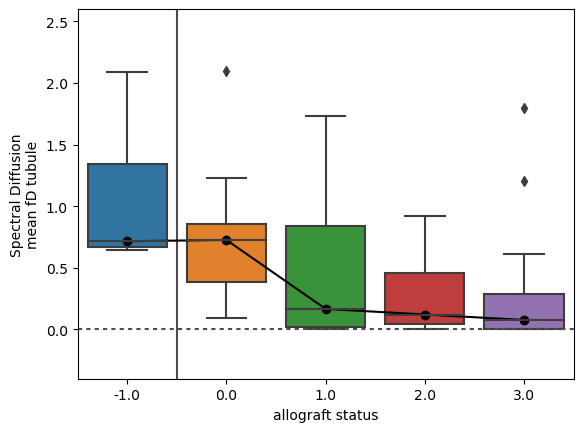

In [17]:
sns.boxplot(x=df_boxplot["allograft status"], y=df_boxplot["fD tubule mean"])#,showmeans=True )
pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.axhline(0, color=".3", dashes=(2, 2))
pl.ylim(-.4, 2.6)
pl.scatter([0,1,2,3,4], [np.median(RA_Database_Volunteer['fD tubule mean']), np.median(df_healthyallo['fD tubule mean']), np.median(df_fibroimpfunc['fD tubule mean']), np.median(df_impfunc['fD tubule mean']), np.median(df_fibro['fD tubule mean'])], color = 'black')
pl.plot([0,1,2,3,4], [np.median(RA_Database_Volunteer['fD tubule mean']), np.median(df_healthyallo['fD tubule mean']), np.median(df_fibroimpfunc['fD tubule mean']), np.median(df_impfunc['fD tubule mean']),np.median(df_fibro['fD tubule mean'])], color = 'black', linestyle = '-')
pl.ylabel('Spectral Diffusion\nmean fD tubule')

pl.show()

In [18]:
print(np.mean(RA_Database_Volunteer['fD tissue mean']), np.mean(df_healthyallo['fD tissue mean']), np.mean(df_fibroimpfunc['fD tissue mean']), np.mean(df_impfunc['fD tissue mean']),np.mean(df_fibro['fD tissue mean']))
print(np.std(RA_Database_Volunteer['fD tissue mean']), np.std(df_healthyallo['fD tissue mean']), np.std(df_fibroimpfunc['fD tissue mean']), np.std(df_impfunc['fD tissue mean']),np.std(df_fibro['fD tissue mean']))


1.9560155677506592 1.5967941747269199 1.7240403564903444 1.686296951895048 1.8574324292042663
0.4945519052750482 0.3041401783069743 0.1575615780335937 0.3049272595855638 0.2735407987801301


In [19]:
print(112.5*np.mean(RA_Database_Volunteer['fD blood mean']), 112.5*np.mean(df_healthyallo['fD blood mean']), 112.5*np.mean(df_fibroimpfunc['fD blood mean']), 112.5*np.mean(df_impfunc['fD blood mean']), 112.5*np.mean(df_fibro['fD blood mean']))
print(112.5*np.std(RA_Database_Volunteer['fD blood mean']), 112.5*np.std(df_healthyallo['fD blood mean']), 112.5*np.std(df_fibroimpfunc['fD blood mean']), 112.5*np.std(df_impfunc['fD blood mean']), 112.5*np.std(df_fibro['fD blood mean']))


605.8038331427779 807.1921822068138 543.0862174872802 688.2658724828871 526.3651245770328
328.57182805514 464.241324559175 577.8212057340519 534.2270843071188 661.1475156458945


In [20]:
print(112.5*np.mean(RA_Database_Volunteer['fD tubule mean']), 112.5*np.mean(df_healthyallo['fD tubule mean']), 112.5*np.mean(df_fibroimpfunc['fD tubule mean']), 112.5*np.mean(df_impfunc['fD tubule mean']),112.5*np.mean(df_fibro['fD tubule mean']))
print(112.5*np.std(RA_Database_Volunteer['fD tubule mean']), 112.5*np.std(df_healthyallo['fD tubule mean']), 112.5*np.std(df_fibroimpfunc['fD tubule mean']), 112.5*np.std(df_impfunc['fD tubule mean']),112.5*np.std(df_fibro['fD tubule mean']))


122.81988837744973 82.28272544070404 45.965502417262385 33.095975035740786 36.04859646341099
63.11230307076784 59.737251837167854 53.95210958925873 35.766198866025995 56.71413351705246
